In [1]:
import numpy as np
import math
from scipy.linalg import qr
from scipy.stats import norm


In [44]:
global dataset_info
dataset_info = ''

def generate_data(n_features, n_samples, cardinality=5, ensure_rep=False, labels=None, seed=42):
   
    d = {'n_features': n_features, 'ix':(n_features-1), 'n_samples': n_samples, 'cardinality': cardinality, 'seed': seed}
    s = '''\
            Number of original features: {n_features}, at columns [0, ..., {ix}]\n\
            Number of samples: {n_samples}\n\
            Cardinality: {cardinality}\n\
            Random seed: {seed}\
        '''.format(**d)
    global dataset_info
    dataset_info += s

    np.random.seed(seed)

    X = np.empty([n_features, n_samples])

    if not isinstance(cardinality, (list, np.ndarray)):

        for i in range(n_features):
            x = _generate_feature(cardinality, n_samples, ensure_rep=ensure_rep)
            X[i] = x

    else:
        default_cardinality = cardinality[0]

        cardinality = [x for x in cardinality if type(x) is tuple]
        
        ix = 0
        for c in cardinality:
            
            if not isinstance(c[0], (list, np.ndarray)): 
                feature_ix = c[0]
                feature_c = c[1]
                
                if ix < feature_ix:
                    for i in range(ix, c[0]):
                        x = _generate_feature(default_cardinality, n_samples, ensure_rep=ensure_rep)
                        X[ix] = x
                        ix += 1

                if not isinstance(feature_c, (list, np.ndarray)): 
                    #print("not list", type(feature_c))
                    x = _generate_feature(feature_c, n_samples, ensure_rep=ensure_rep)
                else:
                    #print("is list", type(feature_c), len(feature_c))
                    x = _generate_feature(feature_c[0], n_samples, ensure_rep=ensure_rep, p=feature_c[1])
                    
                X[ix] = x
                ix += 1
                
            else:
                feature_ixs = c[0]
                feature_c = c[1]
                
                for feature_ix in feature_ixs:
                    if ix < feature_ix:
                        for i in range(ix, feature_ix):
                            x = _generate_feature(default_cardinality, n_samples, ensure_rep=ensure_rep)
                            X[ix] = x
                            ix += 1

                    if not isinstance(feature_c, (list, np.ndarray)):  
                        x = _generate_feature(feature_c, n_samples, ensure_rep=ensure_rep)
                    else:
                        x = _generate_feature(feature_c[0], n_samples, ensure_rep=ensure_rep, p=feature_c[1])
                    X[ix] = x
                    ix += 1

        if ix < n_features:
            for i in range(ix, n_features):
                x = _generate_feature(default_cardinality, n_samples, ensure_rep=ensure_rep)
                X[i] = x
            
    return X.T

def generate_data_features(n_features, n_samples, distribution_function=None, p=0.5, cardinality=5, seed=42):

    if distribution_function is None:
        distribution_function = lambda n, size: np.random.binomial(n=(n-1), p=p, size=size)
    
    np.random.seed(seed)

    X = np.empty([n_features, n_samples])
    if type(cardinality) is not list:  
        
        for i in range(n_features):
            x = distribution_function(n=cardinality, size=n_samples)
            X[i] = x
    else:
        
        default_cardinality = cardinality[0]
        cardinality = [x for x in cardinality if type(x) is tuple]

        c = cardinality[0]
        ix = 0
        if c[0] is not list:
            if c[0] > 0:
                for i in range(c[0]):
                    print("at ix", ix, "should be", default_cardinality)
                    x = distribution_function(n=default_cardinality, size=n_samples)
                    X[i] = x
                    ix+=1
        
        for i in range(0, len(cardinality)):
            c = cardinality[i]
            if c[0] is not list:
                if ix < c[0]:
                    for j in range(ix, c[0]):
                        print("at ix", ix, "should be", default_cardinality)
                        x = distribution_function(n=default_cardinality, size=n_samples)
                        X[ix] = x
                        ix+=1
                
                print("at ix", c[0], "should be", c[1])
                x = distribution_function(n=c[1], size=n_samples)
                X[ix] = x
                ix+=1
            else:
                feature_ixs = c[0]

                for f_ix in feature_ixs:
                    if ix < f_ix:
                        for j in range(ix, feature_ixs[0]):
                            x = distribution_function(n=default_cardinality, size=n_samples)
                            X[ix] = x
                            ix += 1

                    x = distribution_function(n=c[1], size=n_samples)
                    X[ix] = x
                    ix += 1
                    

        if ix < n_features:
            for i in range(ix, n_features):
                print("at ix", ix, "should be", default_cardinality)
                x = distribution_function(n=default_cardinality, size=n_samples)
                X[i] = x
                ix+=1

    return X.T
            

def _generate_feature(v, size, ensure_rep=False, p=None):

    
    
    if not isinstance(v, (list, np.ndarray)):
        v = np.arange(0, v, 1)
    if p is None:
        v_shift = v - v[np.random.randint(len(v))]
        p = norm.pdf(v_shift, scale=3)
        p = p/p.sum()

    #print("_g_f:", len(v), len(p))
    
    if ensure_rep and len(v) < size:
        sampled_values = np.random.choice(v, size=(size-len(v)), p=p)
        sampled_values = np.append(sampled_values, v)     
    else:
        sampled_values = np.random.choice(v, size=size, p=p)

    np.random.shuffle(sampled_values)
    return sampled_values

def generate_combinations(X, feature_indices, combination_function=None, combination_type='linear'):

    d = {'ixs': feature_indices, 'combination_ix': len(X[0])}
    
    selected_features = X[:, feature_indices]

    if combination_function is None:
        if combination_type == 'linear':
            combination_function = lambda x: np.sum(x, axis=1)
            d['func'] = 'linear'
        elif combination_type == 'nonlinear':
            combination_function = lambda x: np.sin(np.sum(x, axis=1))
            d['func'] = 'nonlinear'
    else:
        d['func'] = 'user defined'
    

    combination_result = combination_function(selected_features)

    s = '''
            Columns {ixs} are {func} combinations, result in column {combination_ix}\
        '''.format(**d)

    global dataset_info
    dataset_info += s
    
    return np.column_stack((X, combination_result))
    
def generate_correlated(X, feature_indices, r=0.8):

    d = {'ixs': feature_indices, 'corr': r, 'f0': len(X[0]), 'fn': (len(X[0]) + len(feature_indices) - 1)}
    
    selected_features = X[:, feature_indices]
    transposed = np.transpose(selected_features)
    correlated_features = []
    
    for t in transposed:

        theta = np.arccos(r)
        t_standard = (t - np.mean(t))/np.std(t)
        
        rand = np.random.normal(0, 1, len(t_standard))
        rand = (rand - np.mean(rand))/np.std(rand)

        M = np.column_stack((t_standard, rand))
        M_centred = (M - np.mean(M, axis=0))

        Id = np.eye(len(t))
        Q = qr(M_centred[:, [0]], mode='economic')[0]
        P = np.dot(Q, Q.T)
        orthogonal_projection = np.dot(Id - P, M_centred[:, 1])
        M_orthogonal = np.column_stack((M_centred[:,0], orthogonal_projection))

        Y = np.dot(M_orthogonal, np.diag(1/np.sqrt(np.sum(M_orthogonal**2, axis=0))))
        corr = Y[:, 1] + (1 /np.tan(theta)) * Y[:, 0]
        

        correlated_features.append(corr)
    """
    for i in range(len(transposed)):
        rho = np.corrcoef(transposed[i], correlated_features[i])
        print(rho)
    """
    correlated_features = np.transpose(correlated_features)

    s = '''
            Columns [{f0}, ..., {fn}] are correlated to {ixs} with a factor of {corr}\
        '''.format(**d)

    global dataset_info
    dataset_info += s
    
    return np.column_stack((X, correlated_features))

def generate_duplicates(X, feature_indices):

    d = {'ixs': feature_indices,'f0': len(X[0]), 'fn': (len(X[0]) + len(feature_indices) - 1)}
    
    selected_features = X[:, feature_indices]

    s = '''
            Columns [{f0}, ..., {fn}] are duplicates of {ixs}\
        '''.format(**d)

    global dataset_info
    dataset_info += s
    
    return np.column_stack((X, selected_features))

def generate_nonlinear_labels(X, n=2, p=0.5, k=2, decision_function=None):
    
    n_samples, n_features = X.shape
    d = {'classn': n, 'nfeatures': n_features}
    
    if decision_function is None:
            decision_function = lambda x: np.sum(k*np.sin(x) + k*np.cos(x), axis=1)
            d['type'] = 'nonlinear, with constant ' + str(k)
    else:
        d['type'] = 'user defined'
    
    if n > 2:
        if type(p) != list:
            p = 1/n
            percentiles = [p*100]
            for i in range(1, n-1):
                percentiles.append(percentiles[i-1] + (p*100))
            
            decision_boundary = decision_function(X)
            p_points = np.percentile(decision_boundary, percentiles)
            
            y = np.zeros_like(decision_boundary, dtype=int)
            for p_point in p_points:
                y += (decision_boundary > p_point)
            
    else:
        decision_boundary = decision_function(X)
        
        p_point = np.percentile(decision_boundary, p*100)
        y = np.where(decision_boundary > p_point, 1, 0)

    s = '''
            Sample-label relationship is {type}, with {classn} target labels.\n\
            Total number of features generated: {nfeatures}\
        '''.format(**d)

    global dataset_info
    dataset_info += s
    
    return y

def generate_linear_labels(X, n=2, p=0.5, k=2, decision_function=None):

    n_samples, n_features = X.shape
    d = {'classn': n, 'nfeatures': n_features}

    if decision_function is None:
        decision_function = lambda x: np.sum(2*x+3, axis=1)
        d['type'] = 'linear, with constant ' + str(k)
    else:
        d['type'] = 'user defined'
    
    if n > 2:
        if type(p) != list:
            p = 1/n
            percentiles = [p*100]
            for i in range(1, n-1):
                percentiles.append(percentiles[i-1] + (p*100))
            
            decision_boundary = decision_function(X)
            p_points = np.percentile(decision_boundary, percentiles)
            
            y = np.zeros_like(decision_boundary, dtype=int)
            for p_point in p_points:
                y += (decision_boundary > p_point)
    
    else:
        decision_boundary = decision_function(X)
        p_point = np.percentile(decision_boundary, p*100)
        y = np.where(decision_boundary > p_point, 1, 0)

    s = '''
            Sample-label relationship is {type}, with {classn} target labels.\n\
            Total number of features generated: {nfeatures}\
        '''.format(**d)

    global dataset_info
    dataset_info += s
    
    return y


def print_dataset(X, y):
    n_samples, n_features = X.shape
    n = 0
    for arr in X:
        print('[', end='')
        for i in range(n_features):
            if i == n_features-1:
                print(arr[i], end='')
            else:
                print(arr[i], end=', ')
        print("], Label: {}".format(y[n]))
        n+=1


In [3]:
cardinality = [35, (0,35), (1,23), (2,34), (3,22)]
X = generate_data(4, 150, cardinality=cardinality, ensure_rep=True, seed=2)

y = generate_linear_labels(X, n=3)

#correlated = [1,2]
#X = generate_correlated(X, correlated, r=0.8)
#X = generate_combinations(X, [0,3], combination_type='linear')
#X = generate_combinations(X, [4,5], combination_type='nonlinear')
#duplicates = [2,3,4]
#X = generate_duplicates(X, duplicates)




#print_dataset(X,y)
print(dataset_info)

            Number of original features: 4, at columns [0, ..., 3]
            Number of samples: 150
            Cardinality: [35, (0, 35), (1, 23), (2, 34), (3, 22)]
            Random seed: 2        
            Sample-label relationship is linear, with constant 2, with 3 target labels.
            Total number of features generated: 4        


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

In [5]:
iris = datasets.load_iris()
irisX = iris.data
irisY = iris.target

irisT = np.transpose(irisX)

for row in irisT:
    tmp = []
    count = 0
    for item in row:
        if item not in tmp:
            count+=1
            tmp.append(item)
    #print(count)

iX_train, iX_test, iy_train, iy_test = train_test_split(irisX, irisY, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Iris Classification Report:")
iRFC = RandomForestClassifier()
iRFC.fit(iX_train, iy_train)
iy_pred = iRFC.predict(iX_test)
print(classification_report(iy_test, iy_pred))

print("Generated Classification Report:")
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))


Iris Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Generated Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.60      0.82      0.69        11
           2       1.00      0.50      0.67         8

    accuracy                           0.73        30
   macro avg       0.81      0.71      0.73        30
weighted avg       0.79      0.73      0.73        30



Text(0.5, 1.0, 'Generated')

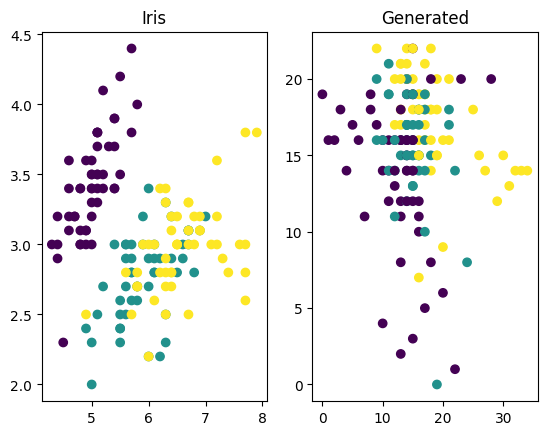

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
scatter1 = ax1.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax1.set_title("Iris")
scatter2 = ax2.scatter(X[:, 0], X[:, 1], c=y)
ax2.set_title("Generated")

Text(0.5, 0.92, 'Iris PCA')

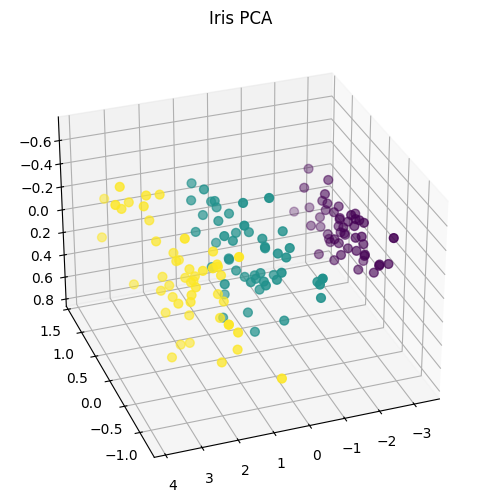

In [7]:
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=iris.target,
    s=40,
)
ax.set_title("Iris PCA")

Text(0.5, 0.92, 'Generated PCA')

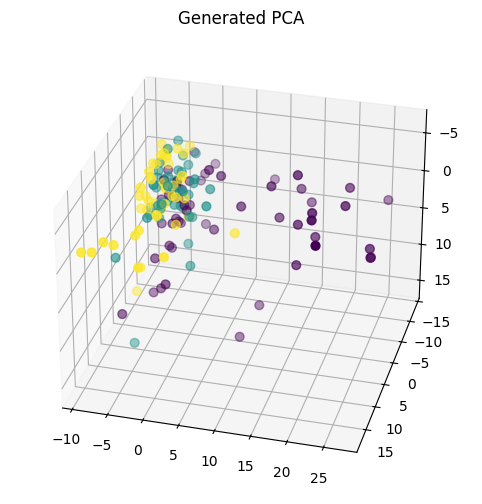

In [8]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=-105)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    s=40,
)
ax.set_title("Generated PCA")

## **TO-DO**:

### Do sestanka Outbrain
- Generacija vektorjev značilk - dodajanje porazdelitev
- Modeliranje Iris:
    - **DELNO**: ~Distribucije značilk dodane~, odmiki?
    - ~Plotanje density histogramov~
    - Dataset similarity -> Google Scholar
    - Funkcija compare_dataset, vizualizacija
    - Github 

### Short-term

- **DELNO**: Generacija vektorjev vrednosti značilk - dodane porazdelitve, morda dodati tudi odmike
- ~Korelirane značilke~, povzeto po [stackexchange](https://stats.stackexchange.com/questions/15011/generate-a-random-variable-with-a-defined-correlation-to-an-existing-variables)
- ~Podvojene značilke~
- **DELNO**: Integriranje delujočih zadev v CC + popravki za generacijo (vse skupaj v eno "main" funkcijo, nabor se generira kot pipeline osnovni sampli -> (ne)linearne kombinacije -> korelirane -> podvojene značilke -> class separation -> šumi in nerelevantni featurji
- Dodatne linearne in nelinearne funkcije tako za kombinacije featurjev kot za separacijo podatkovnega nabora (hypersphere popravki za nelinearne podatkovne nabore + optimizacija tega) => problem s kardinalnostjo rezultatov kombinacij
- **DELNO**: Komentiranje + dokumentacija
- Dodajanje preverjanja tipov argumentov, splošni error message-i
- Podpora večih linearnih in nelinearnih kombinacij, trenutno se za dan input značilk zgenerira ena nova značilka, ki predstavlja kombinacijo danih

### Long-term
- ~**Multi-class support** (trenutno samo binary)~ [DONE]
- **DELNO**: Rework razreda CategoricalClassification za večjo preglednost nad generiranim naborom -> nekaj podobnega kot Keras NN model.summary
- Sinteza sampla dejanskega podatkovnega nabora na podlagi culsteringa/random forest (članek citiran v disp.)
- Nekaj funkcij za vizualizacijo generiranega dataseta 

### Testiranje
- Unit testi
- **DELNO**: "Modeliranje" nekaterih toy datasetov (Iris, Wine, Breast Cancer - SciPy) => mera podobnosti(?)

Pisanje magistrskega dela.


In [9]:
def test(cardinality, nf, Ns):
    if type(cardinality) is not list:
        print(cardinality)
    else:
        default = cardinality[0]
        cardinality = [x for x in cardinality if type(x) is tuple]
        print(default)
        print(cardinality)

        
def test_dist(distribution_function=None):
    distribution_function = lambda n, size: np.random.binomial(n=n, p=0.5, size=size)
    n = distribution_function(n=10, size=100)
    print(print(np.unique(n)))


In [10]:
test_dist()

[1 2 3 4 5 6 7 8 9]
None


In [11]:
np.random.seed(0)
a = np.random.binomial(10, 0.5, 100)
print(np.unique(a))

[1 2 3 4 5 6 7 8]


In [12]:
X = generate_data_features(4, 150, cardinality=[35, (0,35), (1,23), (2,34), (3,22)])
X = X.T
for i in range(len(X)):
    print(i, len(np.unique(X[i])))

at ix 0 should be 35
at ix 1 should be 23
at ix 2 should be 34
at ix 3 should be 22
0 14
1 12
2 14
3 14


In [13]:
from scipy.stats import norm
import matplotlib.pyplot as plt
def _generate_feature(v, size, ensure_rep=False, p=None):
    #np.random.seed(42)
    if type(v) is not list:
        v = np.arange(0, v, 1)
        
    mid = np.random.randint(len(v))
    mid = len(v)//2
    vR = v[4:]
    vL = v[:4]
    print(len(vR) + len(vL), len(v))
    if p is None:
        pR = norm.pdf(vR, scale=3)
        pR = pR / pR.sum()
        pL = norm.pdf(vL, scale=3)
        pL = pL / pL.sum()
        pL = np.flip(pL)
        print(len(pR), pR)
        print(len(pL), pL)
        p = np.append(pL, pR)
        p = p / p.sum()
        #p = np.roll(p, np.random.randint(len(v)/2))
        
    
    if ensure_rep and len(v) < size:
        sampled_values = np.random.choice(v, size=(size - len(v)), p=p)
        sampled_values = np.append(sampled_values, v)     
    else:
        sampled_values = np.random.choice(v, size=size, p=p)

    np.random.shuffle(sampled_values)
    return sampled_values

def _generate_feature1(v, size, ensure_rep=False, p=None):
    #np.random.seed(42)
    if not isinstance(v, (list, np.ndarray)): 
        v = np.arange(0, v, 1)
        
    v_shift = v - v[np.random.randint(len(v))]
    
    if p is None:
        
        p = norm.pdf(v_shift, scale=3)
        p = p/p.sum()
    
    if ensure_rep and len(v) < size:
        sampled_values = np.random.choice(v, size=(size - len(v)), p=p)
        sampled_values = np.append(sampled_values, v)     
    else:
        sampled_values = np.random.choice(v, size=size, p=p)

    np.random.shuffle(sampled_values)
    return sampled_values

(array([ 641.,  893., 1105., 1374., 1511., 1412., 1225.,  917.,  575.,
         347.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

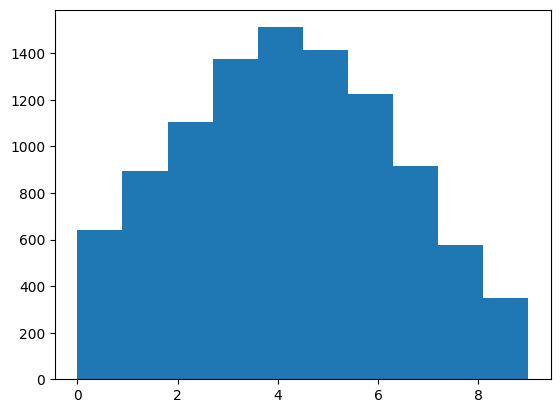

In [14]:
a = _generate_feature1(10, 10000)

plt.hist(a, bins = 10)

35 35
23 23
43 43
22 22


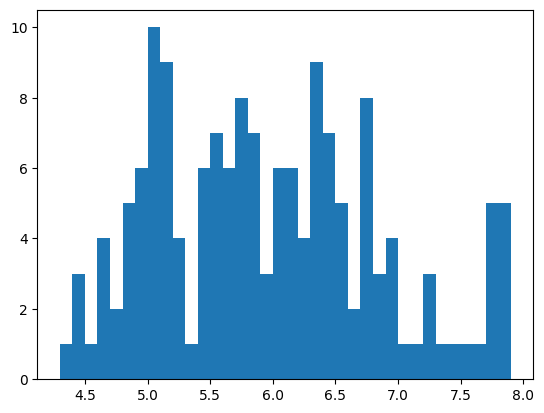

In [38]:
irisFsets = []
irisProbabilities = []
for feature in irisT:
    unique, count = np.unique(feature, return_counts=True)
    irisFsets.append(unique)
    irisProbabilities.append(count/150)

for i in range(4):
    print(len(irisFsets[i]), len(irisProbabilities[i])) 

plt.hist(irisT[0], bins=np.unique(irisT[0]))
plt.show()

150


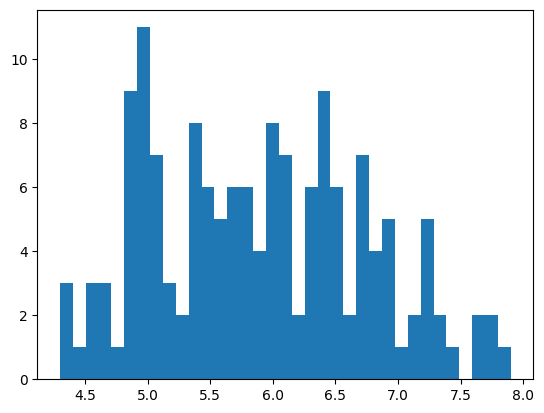

In [34]:
a = _generate_feature1(irisFsets[0], size=150, ensure_rep=True, p=irisProbabilities[0])
print(len(a))
plt.hist(a, bins = len(np.unique(a)))
plt.show()

In [46]:
c = [
        5, 
        (0, [irisFsets[0], irisProbabilities[0]]), 
        (1, [irisFsets[1], irisProbabilities[1]]), 
        (2, [irisFsets[2], irisProbabilities[2]]),
        (3, [irisFsets[3], irisProbabilities[3]])
    ] 

X = generate_data(4, 150, cardinality=c, ensure_rep=True)
y = generate_linear_labels(X, n=3)

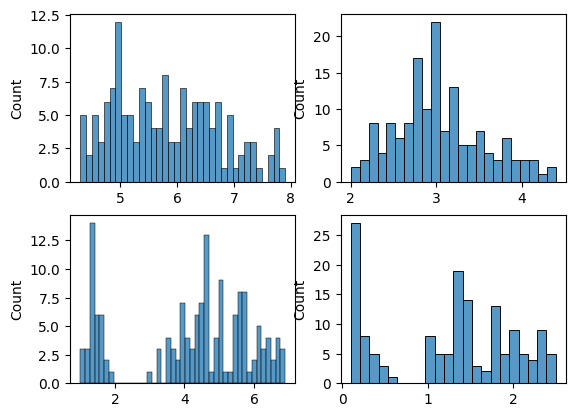

In [49]:
import seaborn as sns
Xt = X.T
fig, axes = plt.subplots(2,2)
sns.histplot(Xt[0], bins=len(np.unique(Xt[0])), ax=axes[0][0])
sns.histplot(Xt[1], bins=len(np.unique(Xt[1])), ax=axes[0][1])
sns.histplot(Xt[2], bins=len(np.unique(Xt[2])), ax=axes[1][0])
sns.histplot(Xt[3], bins=len(np.unique(Xt[3])), ax=axes[1][1])
plt.show()